In [1]:
!unzip -q /content/archive.zip -d /content

In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications import xception
import zipfile
import sys
import time
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

print('Setup successful!')


Setup successful!


In [3]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/content/garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


In [4]:
import os
import pandas as pd
import re

# Add class name prefix to filename. So for example "/paper104.jpg" becomes "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d", x).start()] + '/' + x)
    return df

# List containing all the filenames in the dataset
filenames_list = []
# List to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ', len(df))


number of elements =  15515


In [5]:
df.head()

,filename,category
0,clothes/clothes4621.jpg,7
1,white-glass/white-glass727.jpg,10
2,battery/battery512.jpg,5
3,shoes/shoes757.jpg,6
4,battery/battery482.jpg,5


green-glass/green-glass143.jpg


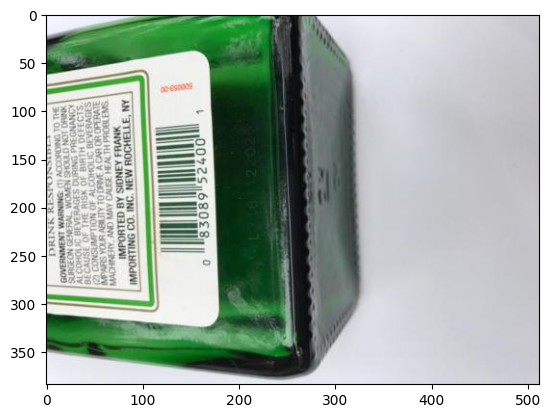

In [6]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

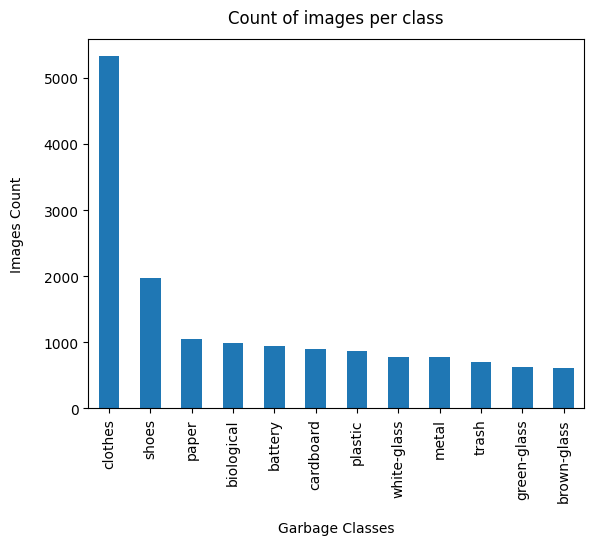

In [7]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [8]:

from keras.models import Sequential
from keras.layers import Dense, Lambda
import keras.applications.xception as xception
import tensorflow as tf

# Load the Xception model without the top layer and with ImageNet weights
xception_layer = xception.Xception(
    include_top=False,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    weights='imagenet'
)

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 320, 320, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │          24,588 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,886,068 (79.67 MB)

 Trainable params: 24,588 (96.05 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [9]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


In [10]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1551 validate size =  1551 test size =  1552


In [20]:
batch_size=32

train_datagen = ImageDataGenerator(

    ###  Augmentation Start  ###

    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2

    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [21]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,               # DataFrame for validation data
    base_path,                 # Path to the directory with validation image files
    x_col='filename',          # Column in the DataFrame with filenames
    y_col='category',          # Column in the DataFrame with labels
    target_size=IMAGE_SIZE,    # Resize images to 320x320
    class_mode='categorical',  # One-hot encode the labels
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


In [27]:
model.add(Dense(12, activation='softmax'))  # 12 classes for classification

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.applications import Xception

model = Xception(include_top=False, input_shape=(320, 320, 3))  # Ensure this matches the input size


In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

In [31]:
EPOCHS = 5

# Compile the model before fitting
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks  # Optional callbacks like EarlyStopping, ModelCheckpoint
)


Epoch 1/5


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 12), output.shape=(None, 10, 10, 2048)

In [26]:
# Check if the generators are working
for x_batch, y_batch in train_generator:
    print(f"Train batch: x_batch shape = {x_batch.shape}, y_batch shape = {y_batch.shape}")
    break  # Check only the first batch

for x_batch, y_batch in validation_generator:
    print(f"Validation batch: x_batch shape = {x_batch.shape}, y_batch shape = {y_batch.shape}")
    break  # Check only the first batch


Train batch: x_batch shape = (32, 320, 320, 3), y_batch shape = (32, 12)
Validation batch: x_batch shape = (32, 320, 320, 3), y_batch shape = (32, 12)


In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import Xception

# Define the input shape
input_layer = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

# Load the Xception model with pre-trained weights, excluding the top (classification) layers
xception_layer = Xception(include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), weights='imagenet')(input_layer)

# Apply Global Average Pooling to reduce the spatial dimensions
x = GlobalAveragePooling2D()(xception_layer)

# Add a fully connected layer for classification with 12 output units (for 12 classes)
output_layer = Dense(12, activation='softmax')(x)

# Define the model with input and output layers
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks  # Optional callbacks like EarlyStopping, ModelCheckpoint
)


Epoch 1/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.8280 - loss: 0.5783

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


387/387 ━━━━━━━━━━━━━━━━━━━━ 464s 991ms/step - accuracy: 0.8281 - loss: 0.5780 - val_accuracy: 0.7507 - val_loss: 3.6597
Epoch 2/5
  1/387 ━━━━━━━━━━━━━━━━━━━━ 5:23 837ms/step - accuracy: 0.9375 - loss: 0.3563

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


387/387 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9375 - loss: 0.3563 - val_accuracy: 0.8667 - val_loss: 0.7772
Epoch 3/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 329s 848ms/step - accuracy: 0.9241 - loss: 0.2405 - val_accuracy: 0.9062 - val_loss: 0.3066
Epoch 4/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9375 - loss: 0.1810 - val_accuracy: 1.0000 - val_loss: 0.0285
Epoch 5/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 372s 844ms/step - accuracy: 0.9582 - loss: 0.1334 - val_accuracy: 0.9225 - val_loss: 0.3076


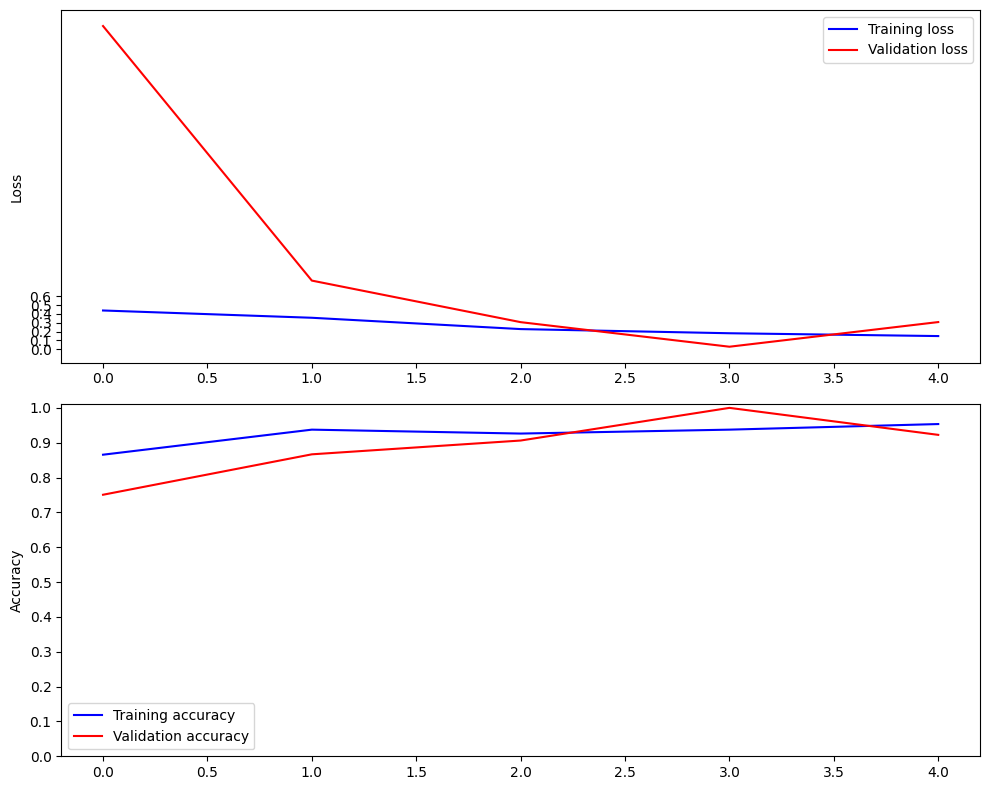

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training and validation loss
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy (use the correct key here)
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_yticks(np.arange(0, 1.1, 0.1))  # Adjust for accuracy values between 0 and 1
ax2.set_ylabel('Accuracy')
ax2.legend()

# Tight layout to prevent overlap
plt.tight_layout()
plt.show()


In [38]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

Found 1552 validated image filenames belonging to 12 classes.


In [41]:
# Get the filenames and the number of samples in the test set
filenames = test_generator.filenames
nb_samples = len(filenames)

# Evaluate the model on the test set
steps = nb_samples // batch_size  # Calculate steps (batches) for evaluation

# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=steps)

# Print the accuracy on the test set
print('Accuracy on test set =', round(accuracy * 100, 2), '%')


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9343 - loss: 0.1819
Accuracy on test set = 87.5 %


In [42]:

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [49]:
# get the model's predictions for the test set
preds = model.predict(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

1552/1552 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step
              precision    recall  f1-score   support

     battery       0.90      0.98      0.93        88
  biological       0.95      0.93      0.94        94
 brown-glass       0.96      0.92      0.94        51
   cardboard       0.93      0.93      0.93        85
     clothes       0.99      0.95      0.97       550
 green-glass       0.88      0.99      0.93        79
       metal       0.88      0.81      0.84        73
       paper       0.95      0.94      0.94       118
     plastic       0.92      0.71      0.80        76
       shoes       0.81      0.96      0.88       184
       trash       0.92      0.87      0.90        70
 white-glass       0.86      0.88      0.87        84

    accuracy                           0.93      1552
   macro avg       0.91      0.91      0.91      1552
weighted avg       0.93      0.93      0.93      1552

